<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Mahdi Shafiei
### Student Number : 99109409
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [60]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimage

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import torch.optim as optim
import torch.backends.cudnn as cudnn

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [62]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head(5)

,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


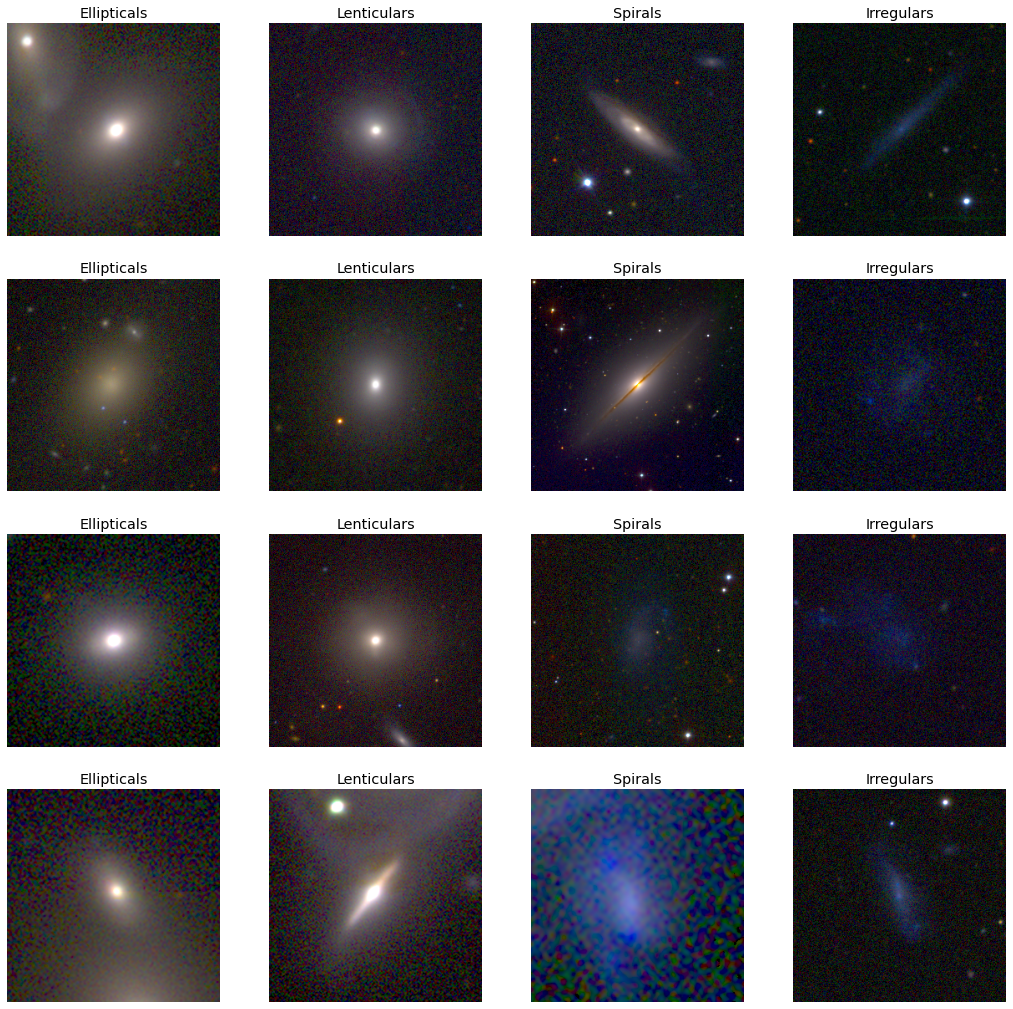

In [63]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################
images = [[] for i in range(4)]
labels = [[] for i in range(4)]
num = 0


for ind in df.index:
    label = df['class_label'][ind]
    name = df['name'][ind]
    c_name = df['class_name'][ind]
    if len(images[label]) < 4:
        images[label].append(name)
        labels[label].append(c_name)
        num = num + 1
    if num >= 16:
        break


plt.figure(figsize=(18, 18))
for i in range(16):
    plt.subplot(4, 4, i+1)
    path = './efigi-1.6/png/' + images[i % 4][i // 4] + '.png'
    im = mpimage.imread(path)
    plt.imshow(im)
    plt.title(labels[i % 4][i // 4])
    plt.axis('off')
plt.show()

# Define Dataset (20 Points)

In [64]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################

class GalaxyDataSet(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [65]:
X = [None for i in range(len(df))]
y = [None for i in range(len(df))]

for ind in df.index:
    label = df['class_label'][ind]
    name = df['name'][ind]
    X[ind] = mpimage.imread('./efigi-1.6/png/' + name + '.png')
    y[ind] = label

In [66]:
X = np.array(X).transpose(0, 3, 1, 2)
y = np.array(y)

train_index, test_index = train_test_split(np.arange(len(X)), test_size=0.2)
train_index, val_index = train_test_split(train_index, test_size=0.2)

In [67]:
train_data = GalaxyDataSet(X[train_index], y[train_index])

In [68]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

In [69]:
val_data = GalaxyDataSet(X[val_index], y[val_index])

In [70]:
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

In [71]:
test_data = GalaxyDataSet(X[test_index], y[test_index])

In [72]:
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [73]:
del X
del train_data
del val_data

# Define Model (20 Points)

In [74]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class ClassifierModel(nn.Module):
    def __init__(self):
        super(ClassifierModel, self).__init__()
        self.base = nn.Sequential(
            nn.AdaptiveAvgPool2d(48),
            nn.Flatten(),
        )
        self.layers = nn.Sequential(
            nn.Linear(6912, 1500),
            nn.Dropout(0.25),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500, 500),
            nn.Dropout(0.1),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, 4),
        )

    def forward(self, x):
        out = self.base(x)
        out = self.layers(out)
        return out

# Train Model (30 Points)

In [78]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################
model = ClassifierModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
accuracy_train = []
accuracy_val = []
f1_train_arr = []
f1_val_arr = []

for epoch in range(50):  # loop over the dataset multiple times
    correct_train = 0
    num_train = 0
    correct_val = 0
    num_val = 0
    f1_train = 0
    f1_val = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = outputs.max(1)
        num_train =  num_train + labels.size(0)
        correct_train = correct_train + predicted.eq(labels).sum().item()
        f1_train += f1_score(labels, predicted, average='macro') * len(labels)
    print('epoch:', epoch, 'train:', correct_train / num_train)
    accuracy_train.append(correct_train / num_train)
    f1_train_arr.append(f1_train / num_train)

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = outputs.max(1)
            correct_val = correct_val + predicted.eq(labels).sum().item()
            num_val = num_val + labels.size(0)
            f1_val += f1_score(labels, predicted, average='macro') * len(labels)
    print('epoch:', epoch, 'valid:', correct_val / num_val)
    accuracy_val.append(correct_val / num_val)
    f1_val_arr.append(f1_val / num_val)
    print()

print('Finished Training')
print('Final Training Accuracy:', correct_train / num_train)
print('Final Validation  Accuracy:', correct_val / num_val)

epoch: 0 train: 0.6420056100981767
epoch: 0 valid: 0.7352941176470589

epoch: 1 train: 0.7542075736325385
epoch: 1 valid: 0.7324929971988795

epoch: 2 train: 0.7633239831697055
epoch: 2 valid: 0.7394957983193278

epoch: 3 train: 0.7689340813464236
epoch: 3 valid: 0.7549019607843137

epoch: 4 train: 0.7808555399719496
epoch: 4 valid: 0.757703081232493

epoch: 5 train: 0.7843618513323983
epoch: 5 valid: 0.7619047619047619

epoch: 6 train: 0.7868162692847125
epoch: 6 valid: 0.7717086834733894

epoch: 7 train: 0.7976858345021038
epoch: 7 valid: 0.7591036414565826

epoch: 8 train: 0.7990883590462833
epoch: 8 valid: 0.7773109243697479

epoch: 9 train: 0.8071528751753155
epoch: 9 valid: 0.7717086834733894

epoch: 10 train: 0.8053997194950911
epoch: 10 valid: 0.7801120448179272

epoch: 11 train: 0.8127629733520336
epoch: 11 valid: 0.788515406162465

epoch: 12 train: 0.8155680224403927
epoch: 12 valid: 0.7829131652661064

epoch: 13 train: 0.820476858345021
epoch: 13 valid: 0.7857142857142857

e

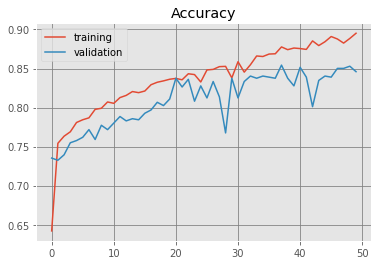

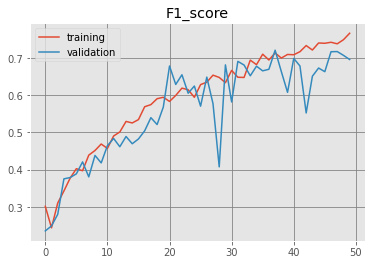

In [79]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.plot(range(len(accuracy_train)), accuracy_train, label='training')
plt.plot(range(len(accuracy_val)), accuracy_val, label='validation')
plt.legend()
plt.title('Accuracy')
plt.grid(color='Gray')
plt.show()

plt.plot(range(len(f1_train_arr)), f1_train_arr, label='training')
plt.plot(range(len(f1_val_arr)), f1_val_arr, label='validation')
plt.legend()
plt.title('F1_score')
plt.grid(color='Gray')
plt.show()

# Test Model (20)

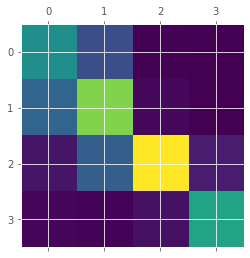

In [80]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

model.eval()
correct_test = 0
num_test = 0
f1_test = 0
confusion_matrix = [[0, 0, 0, 0] for i in range(4)]
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = outputs.max(1)
        num_test += labels.size(0)
        for j in range(len(labels)):
            la = labels[j]
            pr = predicted[j]
            confusion_matrix[la][pr] += 1
confusion_matrix = np.array(confusion_matrix)
plt.matshow(confusion_matrix / np.sum(confusion_matrix, axis=1))
plt.show()